In [2]:
import numpy as np
import pandas as pd
import nannyml as nml
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [3]:
def train_val_test_split(data, target, n_train, n_val):
    # start train index is generated randomly and we make sure
    # to leave space of the validation and test
    idx_train_start = np.random.randint(0, len(data) - n_train - n_val - n_test)
    idx_train_end = idx_train_start + n_train

    # validation set is adjacent to the train set
    idx_val_start = idx_train_end
    idx_val_end = idx_val_start + n_val

    # test set can be at any point after the validation set
    # it doesn't need to be adjacent to it
    # idx_test_start = np.random.randint(idx_val_end, len(data) - n_test)
    # idx_test_end = idx_test_start + n_test
    idx_test_start = idx_val_end + 1
    idx_test_end = len(data) - 1
    
    # split data
    X_train = data.iloc[idx_train_start:idx_train_end]
    X_val = data.iloc[idx_val_start:idx_val_end]
    X_test = data.iloc[idx_test_start:idx_test_end]

    # split targets
    y_train = target.iloc[idx_train_start:idx_train_end]
    y_val = target.iloc[idx_val_start:idx_val_end]
    y_test = target.iloc[idx_test_start:idx_test_end]
    
    # TODO: return only 3 objects df_train, ... targets next to data
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def compute_model_errors(data, target, model, n_train, n_val):
    # create random split
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data, target, n_train, n_val)
    
    # train the model
    model.fit(X_train, y_train)
    
    # make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # calculate errors
    train_errors = np.abs(y_train - y_train_pred)
    val_errors = np.abs(y_val - y_val_pred)
    test_errors = np.abs(y_test - y_test_pred)
    
    return train_errors, val_errors, test_errors

In [5]:
def generate_model_errors_dataframe(train_errors, val_errors, test_errors):
    train_errors_df = pd.DataFrame(train_errors)
    train_errors_df['partition'] = 'train'

    val_errors_df = pd.DataFrame(val_errors)
    val_errors_df['partition'] = 'val'

    test_errors_df = pd.DataFrame(test_errors)
    test_errors_df['partition'] = 'test'

    errors_df = pd.concat([train_errors_df, val_errors_df, test_errors_df])
    errors_df['index'] = errors_df.index
    errors_df = errors_df.rename(columns={"MedHouseVal": "error"})
    errors_df['model_age'] = (errors_df.index - val_errors.index[-1]).days
    
    return errors_df

In [6]:
def evaluation_runner(data, target, model, n_train, n_val, n_simulations=1):
    
    # empty error lists
    errors_df_list = []
    
    # for every simulation compute the models errors, append the errors to the error lists
    for _ in range(n_simulations):
        train_errors, val_errors, test_errors = compute_model_errors(data, target, model, n_train, n_val)
    
        # generate a single error dataframe
        errors_df = generate_model_errors_dataframe(train_errors, val_errors, test_errors)
        errors_df_list.append(errors_df)
    
    errors_df = pd.concat(errors_df_list)
    
    return errors_df

In [9]:
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
timestamp = pd.date_range(start='1/1/2018', periods=len(data), freq='H')
data.index = timestamp
target.index = timestamp

n_train = 5000
n_val = 1000
n_test = 1000 # fix this because n_test is not a parameter
model = LinearRegression()

errors_df = evaluation_runner(data, target, model, n_train, n_val, n_simulations=2)

In [10]:
errors_df

,error,partition,index,model_age
2019-06-02 05:00:00,0.168539,train,2019-06-02 05:00:00,-250
2019-06-02 06:00:00,0.026820,train,2019-06-02 06:00:00,-250
2019-06-02 07:00:00,0.054637,train,2019-06-02 07:00:00,-250
2019-06-02 08:00:00,0.166946,train,2019-06-02 08:00:00,-250
2019-06-02 09:00:00,0.091314,train,2019-06-02 09:00:00,-250
...,...,...,...,...
2020-05-09 18:00:00,0.227391,test,2020-05-09 18:00:00,307
2020-05-09 19:00:00,0.428235,test,2020-05-09 19:00:00,307
2020-05-09 20:00:00,0.015467,test,2020-05-09 20:00:00,307
2020-05-09 21:00:00,0.486901,test,2020-05-09 21:00:00,307


In [11]:
errors_df[errors_df['partition'] == 'test']['model_age'].min()

0

In [29]:
val_mean_error = errors_df[errors_df['partition'] == 'val']['error'].mean()
val_std_error = errors_df[errors_df['partition'] == 'val']['error'].std()
lower_threshold = 0 # train_mean_error - 3 * train_std_error
upper_threshold = val_mean_error + 3 * val_std_error

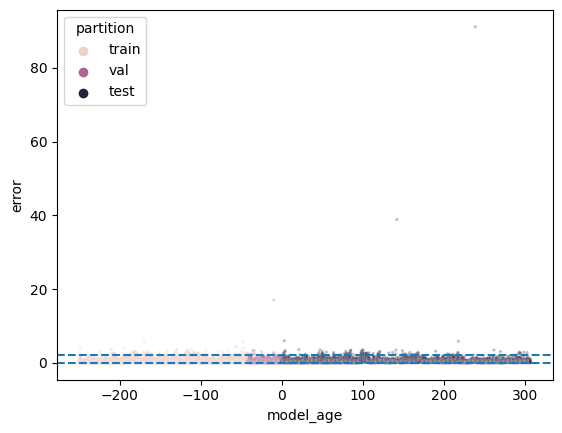

In [30]:
sns.scatterplot(data=errors_df, x='model_age', y='error', hue='partition', s=5,
                palette=sns.cubehelix_palette(n_colors=3), alpha=0.3)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

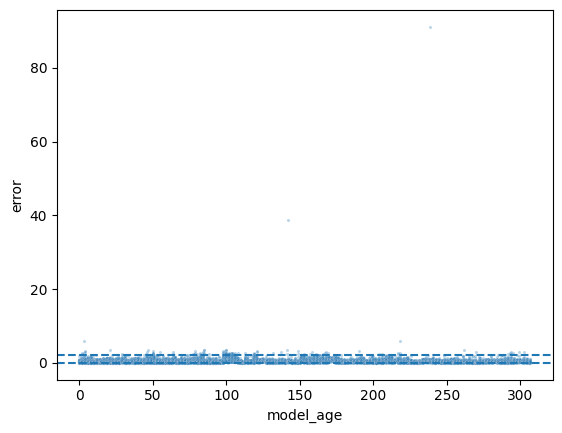

In [31]:
sns.scatterplot(data=errors_df[errors_df['partition'] == 'test'], x='model_age', y='error',
                s=5, alpha=0.3)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

TODO:

- validate that this make sense
- elaborate on the plots
- plot aggregated error of simulations
- review thresholds